In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none' # export SVG text as text, not paths
plt.rcParams['axes.facecolor'] = 'w' # white axes background
plt.rcParams['savefig.facecolor'] = 'w' # white main background, for blog posts

# Initialize a digraph based on monotype effectiveness
Let each of the 18 types be a node in a digraph. For all pairs of types (U,V), define the weight of edge(U,V) as follows:

- Start with E(U,V) = 0
- If U is super-effective against V (x2), add 1 to E(U,V)
- If U resists V (x1/2 damage), add 1 to E(U,V)
- If U is immune to V (x0 damange), add 2 to E(U,V)

## 1.1 Converting table to graph and visualizing

In [3]:
''' Rows = offensve, Columns = Defense '''
df_effectiveness = pd.read_csv('data/monotypes.csv', index_col=0)
df_effectiveness.head()

,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
Bug,1.0,2.0,1.0,1.0,0.5,0.5,0.5,0.5,0.5,2.0,1.0,1.0,1.0,0.5,2.0,1.0,0.5,1.0
Dark,1.0,0.5,1.0,1.0,0.5,0.5,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0
Dragon,1.0,1.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0
Electric,1.0,1.0,0.5,0.5,1.0,1.0,1.0,2.0,1.0,0.5,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
Fairy,1.0,2.0,2.0,1.0,1.0,2.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,0.5,1.0


In [4]:
type_colors = {
    'Bug': '#A6B91A',
    'Dark': '#705746',
    'Dragon': '#6F35FC',
    'Electric': '#F7D02C',
    'Fairy': '#D685AD',
    'Fighting': '#C22E28',
    'Fire': '#EE8130',
    'Flying': '#A98FF3',
    'Ghost': '#735797',
    'Grass': '#7AC74C',
    'Ground': '#E2BF65',
    'Ice': '#96D9D6',
    'Normal': '#A8A77A',
    'Poison': '#A33EA1',
    'Psychic': '#F95587',
    'Rock': '#B6A136',
    'Steel': '#B7B7CE',
    'Water': '#6390F0'
}

In [5]:
G = nx.DiGraph()
ntypes = df_effectiveness.shape[0]

''' Adding nodes to graph and setting their colors '''
node_colors = []
for ptype in df_effectiveness.index:
    G.add_node(ptype)
    node_colors.append(type_colors[ptype])

''' Adding edges and edge weights '''
edge_widths = []
for i in range(ntypes):
    ptype_i = df_effectiveness.index[i]
    for j in range(ntypes):
        ptype_j = df_effectiveness.index[j]
        score = 0
        if df_effectiveness.iloc[i,j] == 2: # offensive effectiveness
            score += 1
        if df_effectiveness.iloc[j,i] == 0.5: # defensive effectiveness - resist
            score += 1
        elif df_effectiveness.iloc[j,i] == 0.0: # defensive effectiveness - immune
            score += 2
        if score > 0:
            G.add_edge(ptype_i, ptype_j, weight=score)
            edge_widths.append(score)
        
#         score = offensive_scores[ df_effectiveness.iloc[i,j] ]
#         i_to_j_score = offensive_scores[ df_effectiveness.iloc[i,j] ]
#         j_to_i_score = offensive_scores[ df_effectiveness.iloc[j,i] ]
#         score = i_to_j_score - j_to_i_score
#         if score > 0:
#             G.add_edge(ptype_i, ptype_j, weight=score)
#             edge_widths.append(score)
#         elif score < 0:
#             G.add_edge(ptype_j, ptype_i, weight=-score)   
#             edge_widths.append(-score)

## 1.2 Type effectiveness graph visualizations

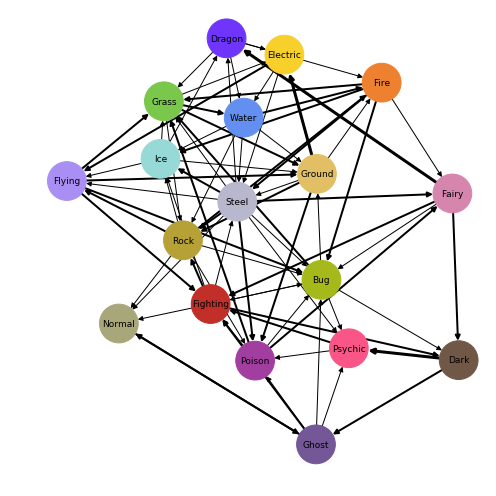

In [6]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx(G, pos, ax=ax, 
                     with_labels=True, font_size=9,
                     node_color=node_colors, node_size=1500,
                     width=edge_widths)

# reducing networkx margins
margin = 0.07
positions = np.array(list(pos.values()))
xmin = np.min(positions[:,0])
xmax = np.max(positions[:,0])
xdiff = xmax - xmin
ymin = np.min(positions[:,1])
ymax = np.max(positions[:,1])
ydiff = ymax - ymin
plt.xlim(xmin - xdiff * margin, xmax + xdiff * margin)
plt.ylim(ymin - ydiff * margin, ymax + ydiff * margin)
plt.axis('off')
plt.tight_layout()

plt.savefig('figures/type_force_directed_graph.png', format='png', dpi=90)

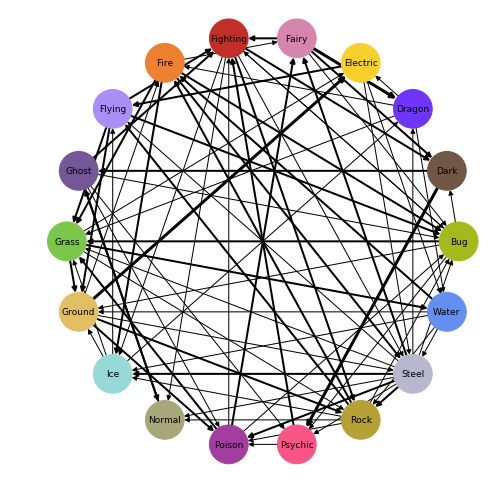

In [7]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
pos = nx.shell_layout(G)
nx.draw_networkx(G, pos, ax=ax, 
                     with_labels=True, font_size=9,
                     node_color=node_colors, node_size=1500,
                     width=edge_widths)

# reducing networkx margins
margin = 0.07
positions = np.array(list(pos.values()))
xmin = np.min(positions[:,0])
xmax = np.max(positions[:,0])
xdiff = xmax - xmin
ymin = np.min(positions[:,1])
ymax = np.max(positions[:,1])
ydiff = ymax - ymin
plt.xlim(xmin - xdiff * margin, xmax + xdiff * margin)
plt.ylim(ymin - ydiff * margin, ymax + ydiff * margin)
plt.axis('off')
plt.tight_layout()

plt.savefig('figures/type_shell_graph.png', format='png', dpi=90)

## 1.2 Rank types by basic degree metrics

In [8]:
degree_scores = {}
for ptype in G.nodes:
    indegree = G.in_degree(ptype) # total weight incoming, i.e. a type-vulnerability score
    outdegree = G.out_degree(ptype) # total weight outcoming, i.e. a type-effectiveness score
    netdegree = outdegree - indegree # net score, net out degree
    degree_scores[ptype] = {'indegree':indegree, 'outdegree':outdegree, 'netdegree':netdegree}
    
df_degree = pd.DataFrame.from_dict(degree_scores).T 
df_degree = df_degree.reindex(columns=['indegree','outdegree', 'netdegree']) # re-order columns
df_degree

,indegree,outdegree,netdegree
Bug,8,5,-3
Dark,4,3,-1
Dragon,4,5,1
Electric,4,4,0
Fairy,3,4,1
Fighting,6,6,0
Fire,5,6,1
Flying,4,4,0
Ghost,3,6,3
Grass,8,5,-3


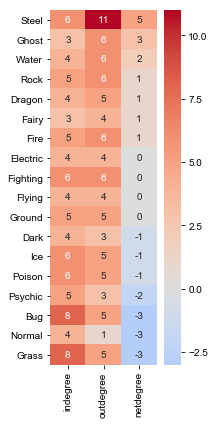

In [11]:
fig,ax = plt.subplots(1,1,figsize=(3,6))
sns.heatmap(df_degree.sort_values(by='netdegree', ascending=False), ax=ax,
            annot=True, fmt='d', cmap='coolwarm', center=0)
plt.tight_layout()

plt.savefig('figures/type_degree_scores.png', format='png', dpi=90)

## 1.3 Rank types by eigencentrality

In [12]:
''' See https://networkx.github.io/documentation/latest/reference/algorithms/generated/networkx.algorithms.centrality.eigenvector_centrality.html 
    Reversing graph to use out-edges to compute centralities'''
eigencentralities = nx.algorithms.eigenvector_centrality(G.reverse(), weight='weight')
df_eigencentralities = (pd.Series(eigencentralities))
df_eigencentralities = pd.DataFrame(df_eigencentralities).rename(columns={0:'eigencentrality'}) # convert Series -> DataFrame
df_eigencentralities

,eigencentrality
Bug,0.173651
Dark,0.097550
Dragon,0.180342
Electric,0.200649
Fairy,0.182530
Fighting,0.207520
Fire,0.358686
Flying,0.266663
Ghost,0.156518
Grass,0.269597


In [13]:
df_eigencentralities.values.mean()

0.21661664664420505

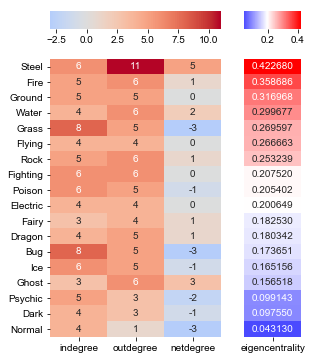

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(4.5,6),
                         gridspec_kw={'height_ratios': [1,15], 'width_ratios': [15,5], 'wspace': 0.2})

eigenranking = df_eigencentralities.sort_values(by='eigencentrality', ascending=False).index
sns.heatmap(df_degree.loc[eigenranking,:], 
            ax=axes[1][0], cbar_ax=axes[0][0], cbar_kws={'orientation':'horizontal'},
            annot=True, fmt='d', cmap='coolwarm', center=0)
sns.heatmap(df_eigencentralities.sort_values(by='eigencentrality', ascending=False), yticklabels=False,
            ax=axes[1][1], cbar_ax=axes[0][1], cbar_kws={'orientation':'horizontal', 'ticks':[0.0,0.2,0.4]}, 
            annot=True, fmt='f', cmap='bwr', center=round(df_eigencentralities.values.mean(),1))

plt.savefig('figures/type_eigencentralities.png', format='png', dpi=90, bbox_inches='tight')